In [ ]:
pip install textstat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.3/105.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.4/939.4 kB 54.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 89.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import spacy
import nltk
import torch
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean

from transformers import BertTokenizer, BertModel, GPT2Tokenizer, GPT2Model, GPT2LMHeadModel
import textstat

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping

# -------------------------------
# 1. Preprocessing & Feature Extraction
# -------------------------------

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# ✅ Set up device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Load dataset (Update file path if needed)
df = pd.read_excel("/content/AI DATASET GET.xlsx")

# ✅ Text preprocessing function
def preprocess_text(text):
    text = re.sub(r'^"""|"""$', '', text)       # Remove leading/trailing triple quotes
    text = re.sub(r'"', '', text)               # Remove remaining double quotes
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove special characters
    text = text.lower()                         # Convert to lowercase
    text = re.sub(r'\s+', ' ', text).strip()    # Remove extra spaces
    return text

df['task'] = df['task'].apply(preprocess_text)

# ✅ Load GPT-2 tokenizer
gpt2_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token

# ✅ Load GPT-2 models
gpt2_lm_model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)  # For perplexity
gpt2_lm_model.eval()

gpt2_embed_model = GPT2Model.from_pretrained("gpt2").to(device)  # For embeddings
gpt2_embed_model.eval()

# ✅ Load BERT model & tokenizer
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased").to(device)



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
# -------------------------------
# 2. Feature Extraction Functions
# -------------------------------

# 🎯 Function to compute GPT-2 perplexity
def calculate_perplexity(text, model, tokenizer):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs, labels=inputs.input_ids)
        loss = outputs.loss
    perplexity = torch.exp(loss).item()
    return perplexity

# 🎯 Function to extract handcrafted linguistic features
def extract_handcrafted_features(text):
    doc = nlp(text)
    word_count = len(doc)
    sentence_count = len(list(doc.sents))
    avg_word_length = np.mean([len(token) for token in doc]) if word_count > 0 else 0
    avg_sentence_length = np.mean([len(sent) for sent in doc.sents]) if sentence_count > 0 else 0
    fog_index = textstat.gunning_fog(text)
    flesch_reading_ease_val = textstat.flesch_reading_ease(text)
    type_token_ratio = len(set([token.text for token in doc])) / word_count if word_count > 0 else 0
    complex_words = sum(1 for token in doc if token.is_alpha and len(token) > 6)
    complex_word_ratio = complex_words / word_count if word_count > 0 else 0
    perplexity = calculate_perplexity(text, gpt2_lm_model, gpt2_tokenizer)

    return {
        'word_count': word_count,
        'sentence_count': sentence_count,
        'avg_word_length': avg_word_length,
        'avg_sentence_length': avg_sentence_length,
        'fog_index': fog_index,
        'flesch_reading_ease': flesch_reading_ease_val,
        'type_token_ratio': type_token_ratio,
        'complex_word_ratio': complex_word_ratio,
        'perplexity': perplexity
    }

# 🎯 Function to extract BERT embeddings
def extract_bert_embedding(text):
    inputs = bert_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    embedding = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
    return embedding

# 🎯 Function to extract GPT-2 embeddings
def extract_gpt2_embedding(text):
    inputs = gpt2_tokenizer(text, return_tensors="pt", truncation=True, max_length=512, padding=True).to(device)
    with torch.no_grad():
        outputs = gpt2_embed_model(**inputs)  # ✅ Using GPT2Model
    embedding = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
    return embedding

# -------------------------------
# 3. Apply Feature Extraction
# -------------------------------

df['handcrafted'] = df['task'].apply(extract_handcrafted_features)
df_features = pd.DataFrame(df['handcrafted'].tolist())

df['bert_embedding'] = df['task'].apply(extract_bert_embedding)
df['gpt2_embedding'] = df['task'].apply(extract_gpt2_embedding)

# -------------------------------
# 4. Train Autoencoder on Combined Features
# -------------------------------

# ✅ Convert GPT-2 embeddings to DataFrame
gpt2_dim = len(df['gpt2_embedding'].iloc[0])
gpt2_cols = [f"gpt2_{i}" for i in range(gpt2_dim)]
df_gpt2 = pd.DataFrame(df['gpt2_embedding'].tolist(), columns=gpt2_cols)

# ✅ Concatenate handcrafted features and GPT-2 embeddings
df_combined = pd.concat([df_features.reset_index(drop=True), df_gpt2.reset_index(drop=True)], axis=1)

# ✅ Scale the combined features
scaler = MinMaxScaler()  # Use MinMaxScaler since we use sigmoid activation
scaled_features = scaler.fit_transform(df_combined)

# ✅ Define Autoencoder architecture
input_dim = scaled_features.shape[1]
encoding_dim = int(input_dim / 2)

autoencoder = Sequential([
    Dense(encoding_dim, activation="relu", input_shape=(input_dim,)),
    Dense(encoding_dim // 2, activation="relu"),
    Dense(encoding_dim, activation="relu"),
    Dense(input_dim, activation="sigmoid")
])
autoencoder.compile(optimizer="adam", loss="mse")

# ✅ Train the autoencoder with early stopping
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
autoencoder.fit(scaled_features, scaled_features, epochs=100, batch_size=32, shuffle=True, verbose=1, callbacks=[early_stopping])

# ✅ Extract Latent Features
input_layer = Input(shape=(input_dim,))
encoded_output = autoencoder.layers[1](autoencoder.layers[0](input_layer))
encoder = Model(inputs=input_layer, outputs=encoded_output)

latent_features = encoder.predict(scaled_features)

# ✅ Save Encoder Model
encoder.save("encoder_model.h5")

print("✅ Autoencoder training completed. Latent features extracted.")



`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0263
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0200
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0161
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0143
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0130
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0118
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0113
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0107
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0101
Epoch 10/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0095
Epoch 11/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0091
Epoch 12/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0087
Epoch 13/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0088
Epoch 14/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0083
Epoch 15/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0084
Epo

✅ Autoencoder training completed. Latent features extracted.


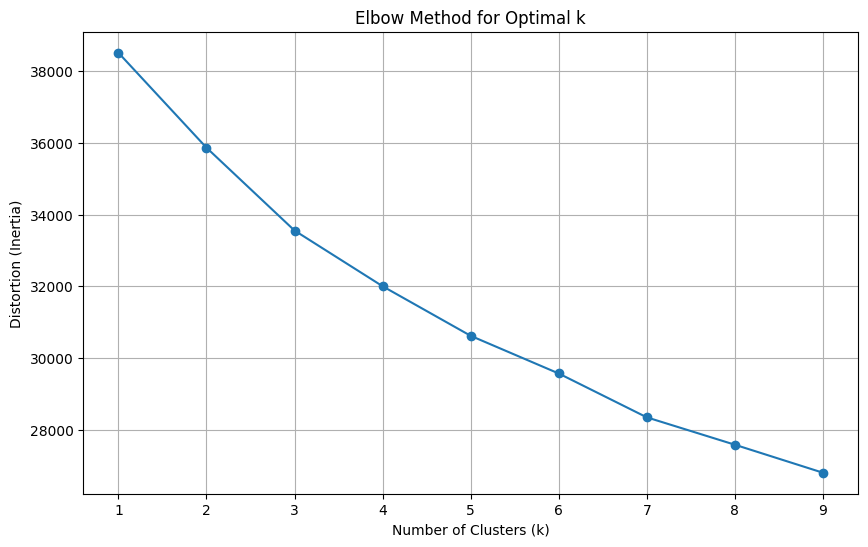

In [ ]:
# Elbow Method to determine the optimal number of clusters
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

distortions = []
K = range(1, 10)  # Try k values from 1 to 10
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(latent_features)
    distortions.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K, distortions, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Distortion (Inertia)')
plt.title('Elbow Method for Optimal k')
plt.xticks(K)
plt.grid(True)
plt.show()



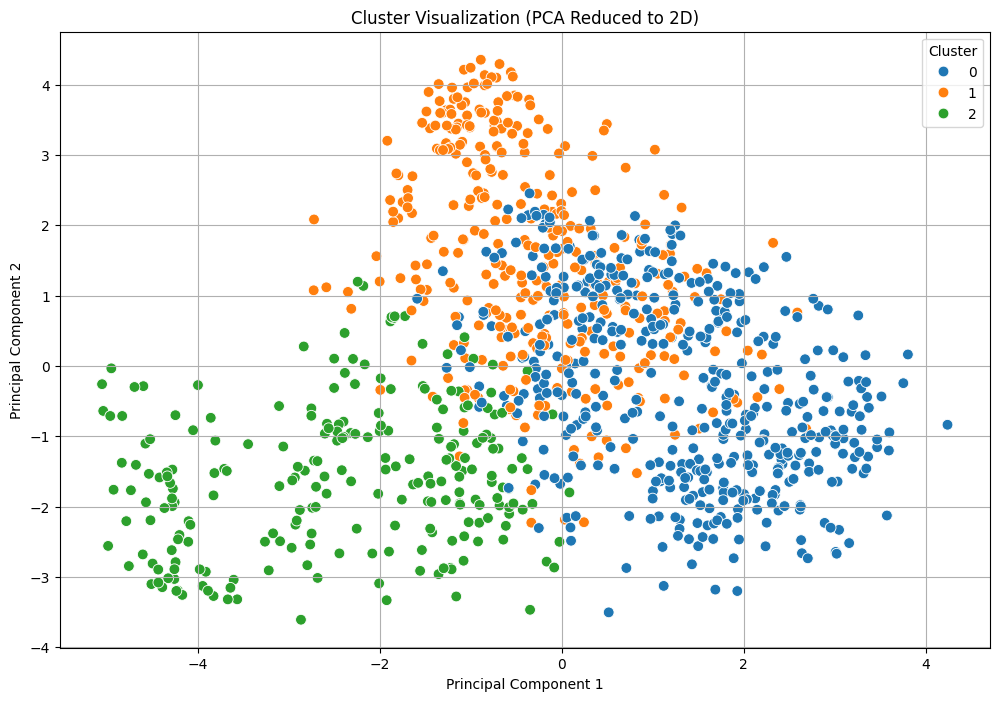

In [ ]:
# 3. Clustering on Latent Representations
# ---------------------------------------------
# Choose an appropriate number of clusters (optimal_k) using the elbow method or domain knowledge.
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(latent_features)
cluster_centers = kmeans.cluster_centers_

# Precompute maximum distances within each cluster for normalization
cluster_max_distance = {}
for cluster in range(optimal_k):
    indices = np.where(clusters == cluster)[0]
    if len(indices) > 0:
        distances = [euclidean(latent_features[i], cluster_centers[cluster]) for i in indices]
        cluster_max_distance[cluster] = max(distances)
    else:
        cluster_max_distance[cluster] = 1.0

from sklearn.decomposition import PCA
import seaborn as sns

# Reduce dimensionality of latent features to 2D for visualization
pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latent_features)

# Create a DataFrame for easy visualization
df_visualization = pd.DataFrame(latent_2d, columns=['PC1', 'PC2'])
df_visualization['Cluster'] = clusters

# Plot the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_visualization, x='PC1', y='PC2', hue='Cluster', palette='tab10', s=60)
plt.title('Cluster Visualization (PCA Reduced to 2D)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


In [ ]:
# For cosine similarity later, prepare training embeddings as matrices:
bert_embeddings_train = np.vstack(df['bert_embedding'].values)
gpt2_embeddings_train = np.vstack(df['gpt2_embedding'].values)

# ---------------------------------------------
# 4. Unified Classification Function with Clustering
# ---------------------------------------------
def classify_response_unified(new_text, scaler, encoder, kmeans, cluster_centers, cluster_max_distance,
                                bert_embeddings_train, gpt2_embeddings_train):
    """
    For a new response, this function computes:
      - A normalized cluster-based latent similarity (using the autoencoder latent space and KMeans clustering),
      - Cosine similarity between the new and training BERT embeddings,
      - Cosine similarity between the new and training GPT2 embeddings.

    These metrics are combined (via tunable weights) into a final probability.
    """
    # Extract features from the new text
    new_handcrafted = extract_handcrafted_features(new_text)
    new_bert_embedding = extract_bert_embedding(new_text)
    new_gpt2_embedding = extract_gpt2_embedding(new_text)

    # Prepare combined features for autoencoder: handcrafted + GPT2 embeddings
    new_features_handcrafted = pd.DataFrame([new_handcrafted])
    new_gpt2_df = pd.DataFrame([new_gpt2_embedding], columns=gpt2_cols)
    new_combined = pd.concat([new_features_handcrafted, new_gpt2_df], axis=1)

    # Scale combined features and obtain latent representation
    scaled_new = scaler.transform(new_combined)
    new_latent = encoder.predict(scaled_new).flatten()

    # --- Metric 1: Clustering-based Latent Similarity ---
    # Determine which cluster the new sample belongs to and compute its normalized distance.
    predicted_cluster = kmeans.predict(new_latent.reshape(1, -1))[0]
    distance_to_center = euclidean(new_latent, cluster_centers[predicted_cluster])
    max_distance_cluster = cluster_max_distance[predicted_cluster] if cluster_max_distance[predicted_cluster] > 0 else 1.0
    normalized_cluster_similarity = 1 - (distance_to_center / max_distance_cluster)

    # --- Metric 2: Cosine similarity using BERT embeddings ---
    new_bert = new_bert_embedding.reshape(1, -1)
    cosine_sim_bert = cosine_similarity(new_bert, bert_embeddings_train)[0].max()

    # --- Metric 3: Cosine similarity using GPT2 embeddings ---
    new_gpt2 = new_gpt2_embedding.reshape(1, -1)
    cosine_sim_gpt2 = cosine_similarity(new_gpt2, gpt2_embeddings_train)[0].max()

    # Combine the metrics with weights (tune these weights based on validation)
    # For example, weights: 0.3 for clustering-based similarity, 0.35 for BERT, and 0.35 for GPT2.
    final_probability = (0.5 * normalized_cluster_similarity +
                         0.25 * cosine_sim_bert +
                         0.25 *cosine_sim_gpt2)

    # Decision threshold (adjust as needed)
    classification = "AI-Generated" if final_probability >= 0.50 else "Likely Human-Written"

    return {
        "Text": new_text,
        "Classification": classification,
        "Probability": final_probability,
        "Cluster-Based Similarity": normalized_cluster_similarity,
        "Cosine Similarity BERT": cosine_sim_bert,
        "Cosine Similarity GPT2": cosine_sim_gpt2,
        "Assigned Cluster": predicted_cluster
    }


# 5. Example Usage
# ---------------------------------------------
# Replace the sample text below with a new response to classify.
new_sample_text = resp24
result = classify_response_unified(new_sample_text, scaler, encoder, kmeans, cluster_centers, cluster_max_distance,
                                   bert_embeddings_train, gpt2_embeddings_train)

print("Classification Result:")
for key, value in result.items():
    print(f"{key}: {value}")